In [1]:
# 01. 라이브러리
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

In [2]:
# 02. 데이터 로딩
df = pd.read_csv('../data/processed_train.csv')
features_all = ['op1', 'op2', 's2', 's3', 's4','s5','s6','s7', 's8', 's9',
                's11', 's12', 's13', 's14', 's15','s16','s17', 's20','s21']
features_wo_s11 = [f for f in features_all if f != 's11']
target = 'RUL_clipped'

In [3]:
# 03. 스케일링
scaler = StandardScaler()
X_all = scaler.fit_transform(df[features_all])
X_wo_s11 = scaler.fit_transform(df[features_wo_s11])
y = df[target]
joblib.dump(scaler, '../models/xgb_scaler_for_ensemble.pkl')

['../models/xgb_scaler_for_ensemble.pkl']

In [4]:
# 04. Train/Validation Split
X_train_all, X_val_all, y_train, y_val = train_test_split(X_all, y, test_size=0.2, random_state=42)
X_train_wo, X_val_wo, _, _ = train_test_split(X_wo_s11, y, test_size=0.2, random_state=42)

In [5]:
# 05. 모델 정의 및 학습
model_with_s11 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_wo_s11 = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

model_with_s11.fit(X_train_all, y_train)
model_wo_s11.fit(X_train_wo, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
# 06. 예측 및 앙상블
pred_with = model_with_s11.predict(X_val_all)
pred_wo = model_wo_s11.predict(X_val_wo)
pred_ensemble = (pred_with + pred_wo) / 2

In [7]:
# 07. 성능 비교
mae_with = mean_absolute_error(y_val, pred_with)
mae_wo = mean_absolute_error(y_val, pred_wo)
mae_ensemble = mean_absolute_error(y_val, pred_ensemble)

print(f"MAE with s11     : {mae_with:.4f}")
print(f"MAE without s11 : {mae_wo:.4f}")
print(f"MAE ensemble     : {mae_ensemble:.4f}")

MAE with s11     : 13.3071
MAE without s11 : 13.4417
MAE ensemble     : 13.2981


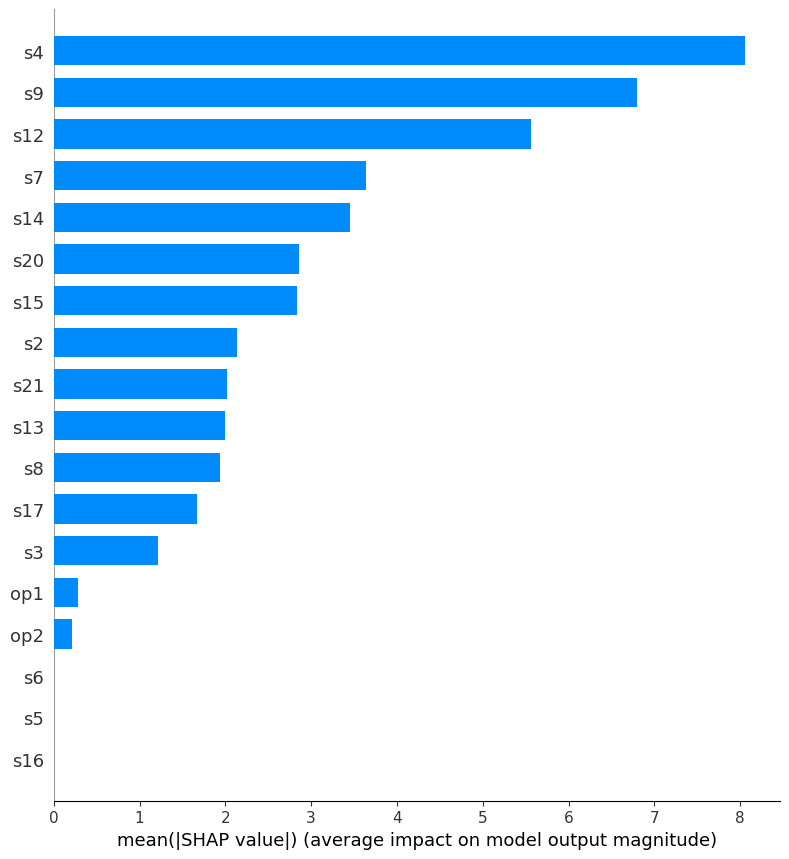

In [10]:
import numpy as np
import shap
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# s11 제거
features = ['op1', 'op2', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
            's12', 's13', 's14', 's15', 's16', 's17', 's20', 's21']
target = 'RUL_clipped'

# 표준화
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# train/val 분할
X = df[features]
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 학습
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# MAE 계산
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(X_val)

# 요약 플롯 출력
plt.figure()
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
plt.tight_layout()
plt.show()